In [2]:
import xarray as xr
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert



In [3]:
%matplotlib notebook

In [4]:
#ds = xr.open_dataset(r'C:/Users/mrayson/cloudstor/Data/IWAtlas\NWS_internal_tide_atlas.nc')
ds = xr.open_dataset(r'/home/suntans/cloudstor/Data/IWAtlas/NWS_internal_tide_atlas.nc')

ds

<xarray.Dataset>
Dimensions:    (depth: 100, frq: 5, latitude: 1000, longitude: 1750, modes: 4, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2013-07-01 2013-08-01 ... 2014-06-01
  * frq        (frq) float64 0.0001405 0.0001454 0.0001379 7.292e-05 6.76e-05
  * modes      (modes) float64 0.0 1.0 2.0 3.0
  * latitude   (latitude) float64 -25.0 -24.98 -24.96 ... -5.06 -5.04 -5.02
  * longitude  (longitude) float64 107.5 107.5 107.5 107.6 ... 142.4 142.5 142.5
  * depth      (depth) float64 3.734 11.46 19.44 ... 5.792e+03 5.996e+03
Data variables:
    amp_b      (time, frq, modes, latitude, longitude) float64 ...
    phs_b      (time, frq, modes, latitude, longitude) float64 ...
    z          (latitude, longitude) float64 ...
    rho        (time, depth, latitude, longitude) float64 ...
Attributes:
    Name:          North West Shelf internal tide amplitude climatology
    Date created:  2018:11:05 21:59:57
    Author:        Matt Rayson
    Institution:   University of West

In [20]:
# Get the amplitude and phase for a given point
lonpt = 123.346383
latpt = -13.75895

lonpt = 122.8
latpt = -12.8

#lonpt = 123.3
#latpt = -14.2

mode = 0

# Rowley shoals offshore site

lonpt = 118.5
latpt = -16.66

t1 = '2013-07-01'
t2 = '2014-06-01'
dt = '30min'



In [21]:
my_amp = ds['amp_b'].sel(longitude=lonpt, latitude=latpt, modes=mode, method='nearest')
my_phs = ds['phs_b'].sel(longitude=lonpt, latitude=latpt, modes=mode, method='nearest')

# Convert to complex form
amp = my_amp*np.cos(my_phs) + 1j*my_amp*np.sin(my_phs)
amp

<xarray.DataArray (time: 12, frq: 5)>
array([[ 0.025398-5.256617j,  0.57644 -1.385203j, -1.447702-0.942137j,
         1.994824-0.830134j,  0.208774+0.358607j],
       [ 3.910953-3.059444j,  0.062553+0.647942j, -1.453046-1.148474j,
         1.079643-0.253258j,  0.351259+0.062957j],
       [ 2.517917+1.500018j, -2.898844-0.728495j,  0.698344-0.594817j,
         0.74518 -0.302596j,  0.414668+0.141558j],
       [ 3.224915-1.018202j, -1.862599+0.277562j, -2.100342-0.630163j,
         0.943947-0.577443j,  0.295606+0.325807j],
       [ 5.811074-8.674998j,  1.417757-1.046516j, -0.371774+1.22922j ,
         1.278922-0.911643j, -0.374978+0.727222j],
       [ 3.974126-7.846614j, -0.055318-1.329745j, -2.2903  +1.750565j,
         1.928409-0.647685j,  0.305837+0.857598j],
       [ 2.100394-6.666294j, -0.678781-2.603072j, -1.047326-0.595919j,
         1.64733 -0.128287j, -0.285899+0.537026j],
       [ 4.84855 -3.797415j, -0.076831-1.241012j, -1.633517+0.331108j,
         1.134251-0.026926j,  0.45168

<IPython.core.display.Javascript object>


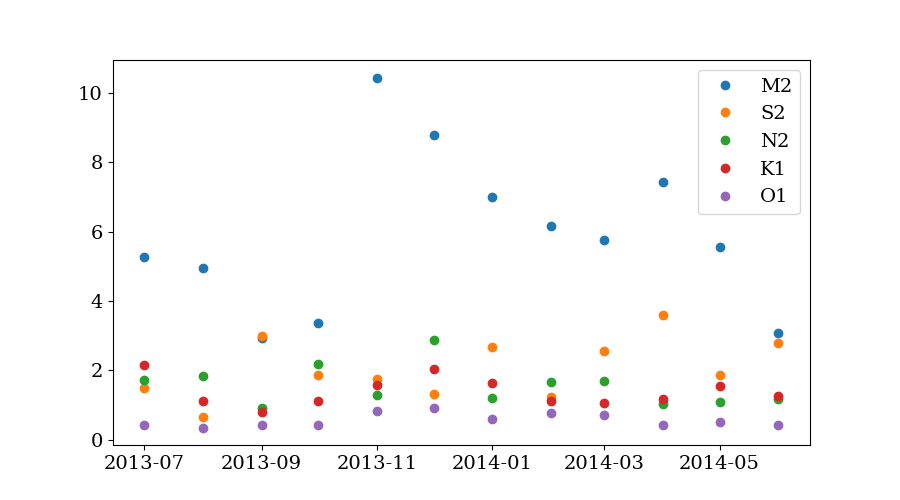

In [37]:
# M2 amplitudes per month

plt.figure(figsize=(9,5))
for ii,ff in enumerate(amp.frq):
    plt.plot(amp.time,np.abs(amp.values[:,ii]),'o')
plt.legend(('M2','S2','N2','K1','O1'))
plt.ylabel('Amp [m]')

In [29]:
# S2 amplitudes per month
np.abs(amp.values[:,1])

array([1.50035646, 0.65095478, 2.98897987, 1.88316647, 1.76216646,
       1.3308954 , 2.69011651, 1.24338848, 2.5597748 , 3.60062915,
       1.86502065, 2.79323356])

In [23]:
# Interpolate the complex amplitude in time
# *note that the phases are since 1990-01-01
newtime = pd.date_range(start=t1, end=t2, freq = dt)

amp_new = amp.resample(time=dt).interpolate('linear').sel(time=newtime)

In [24]:
t1990 = (amp_new.time.values - np.datetime64('1990-01-01')).astype('timedelta64[s]').astype(float)
t1990

array([7.414848e+08, 7.414866e+08, 7.414884e+08, ..., 7.704252e+08,
       7.704270e+08, 7.704288e+08])

In [25]:
# Reconstruct the time series
amp_ts = np.zeros(t1990.shape[0], dtype=np.float)
for ii,ff in enumerate(amp.frq.values):
    amp_ts += np.real(amp_new.values[:,ii]*np.exp(-1j*ff*t1990))
    

In [26]:
# Calculate the envelope
amp_ts_h = hilbert(amp_ts)
env = np.abs(amp_ts_h)

<IPython.core.display.Javascript object>


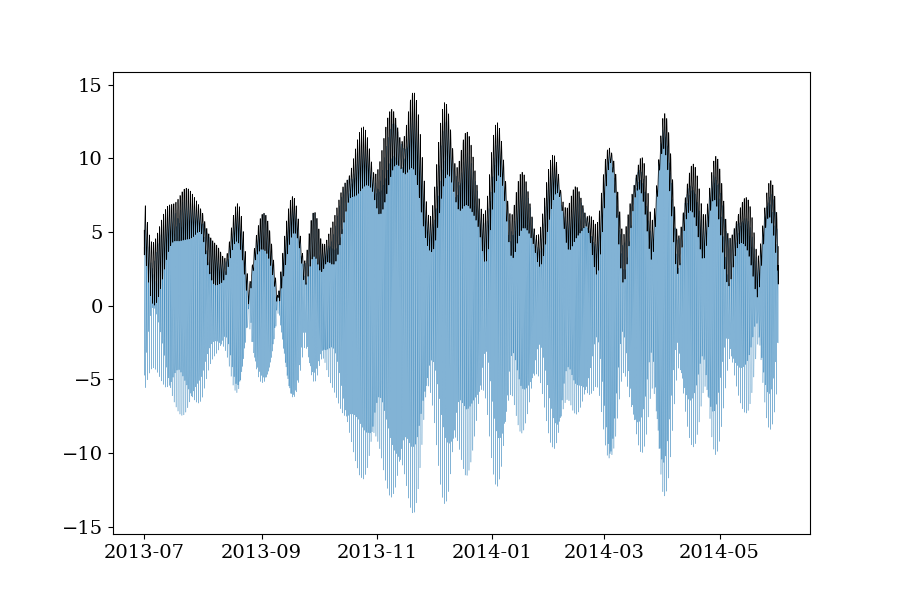

In [27]:
plt.figure(figsize=(9,6))
plt.plot(amp_new.time, amp_ts, lw=0.2)
plt.plot(amp_new.time, env, lw=0.5, c='k')

6.759774415077306e-05

In [48]:
t1990


array([7.414848e+08, 7.441632e+08, 7.468416e+08, 7.494336e+08,
       7.521120e+08, 7.547040e+08, 7.573824e+08, 7.600608e+08,
       7.624800e+08, 7.651584e+08, 7.677504e+08, 7.704288e+08])